**Import required packages**

In [209]:
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as k
from sklearn.model_selection import train_test_split

**Importing data from an online repository**

In [210]:
seq_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'
label_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'
sequences = requests.get(seq_URL).text.split('\n')
sequences = list(filter(None, sequences))
labels = requests.get(label_URL).text.split('\n')
labels = list(filter(None, labels))
labels = [float(i) for i in labels]

Build a one hot encoding function and encode our genomic sequences into a numeric representation. ***Recall*** machine learning algorithms can work only with numeric data. The one hot encoding is the goal standard as of now in encoding sequences.

In [211]:
codes = {'A': [1, 0, 0, 0], 
         'C': [0, 1, 0, 0], 
         'G': [0, 0, 1, 0], 
         'T': [0, 0, 0, 1]}

def one_hot(sequence, code):
    encoded_seq = np.zeros(shape=(4, len(sequence)))
    for i, nt in enumerate(sequence):
        encoded_seq[:, i] = code[nt]
    return encoded_seq


encoded_sequences = np.expand_dims(np.array([one_hot(seq, codes) for seq in sequences]), 3)
labels = to_categorical(np.array(labels), 2)

Next step is building a function that holds our convolutional neural network model. We build a simple CNN since our task is not that complicated. We will use one **convolutional layer**, followed by a **maxpooling layer**. Maxpooling layers are subsampling layers. Then we use **fully connected** layer (named *Dense* by tensorflow). Then our **output layer** with two neurons, where each neuron represents either contains or lacks the TF binding site.

In [212]:
def network(x_train, y_train, x_test, y_test):
    k.clear_session()
    model = Sequential()
    model.add(Conv2D(32, kernel_size=12, activation='relu', input_shape=(4, 50, 1), padding='same'))
    model.add(MaxPool2D(pool_size=4))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
    print(model.summary())

    model.fit(x_train, y_train, batch_size=50, epochs=50, validation_data=(x_test, y_test))

    return model

Now we can split our data into a training and test set. We use the stratify option to ensure that the distribution of the training and test sets are the same. This is equivalent to producing balanced datasets.




In [213]:
X_train, X_test, Y_train, Y_test = train_test_split(encoded_sequences, labels, test_size=0.2, random_state=42,
                                                    stratify=labels)

model = network(X_train, Y_train, X_test, Y_test)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 50, 32)         4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 12, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                6160      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 10,834
Trainable params: 10,834
Non-trainable params: 0
_________________________________________________________________
None
Train on 1600 samples, validate on 400 samples
Epoch 1/50
1600/1600 [==============================] - 1s 653us/s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1600/1600 [==============================] - 1s 594us/sample - loss: 0.5916 - binary_accuracy: 0.8662 - val_loss: 0.5213 - val_binary_accuracy: 0.8750
Epoch 3/50
1600/1600 [==============================] - 1s 573us/sample - loss: 0.4145 - binary_accuracy: 0.8963 - val_loss: 0.3377 - val_binary_accuracy: 0.9200
Epoch 4/50
1600/1600 [==============================] - 1s 576us/sample - loss: 0.2473 - binary_accuracy: 0.9550 - val_loss: 0.2083 - val_binary_accuracy: 0.9575
Epoch 5/50
1600/1600 [==============================] - 1s 586us/sample - loss: 0.1476 - binary_accuracy: 0.9787 - val_loss: 0.1348 - val_binary_accuracy: 0.9750
Epoch 6/50
1600/1600 [==============================] - 1s 581us/sample - loss: 0.0898 - binary_accuracy: 0.9894 - val_loss: 0.0949 - val_binary_accuracy: 0.9825
Epoch 7/50
1600/1600 [==============================] - 1s 579us/sample - loss: 0.0601 - binary_accuracy: 0.9931 - val_loss: 0.0657 - val_binary_accuracy: 0.9950
Epoch 8/50
1600/1600 [=================

Next we investigate our trained model to understand what it learns. We we wish to understand which regions within the data was the distinguishing factor between TF binding site containing and not containg sequences. We can compute a simple saliency map, which is the gradient of the model's prediction with respect to each individual nucleotide.


---
The saliency maps shows how the output response value changes with respect to a small changes in input nucleotide sequence. All the positive values in the gradients tell us that a small change to that nucleotide will change the output value. Hence, visualizing these gradients for a given input sequence, should provide some clues about what nucleotides form the binding motive that we are trying to identify.



540


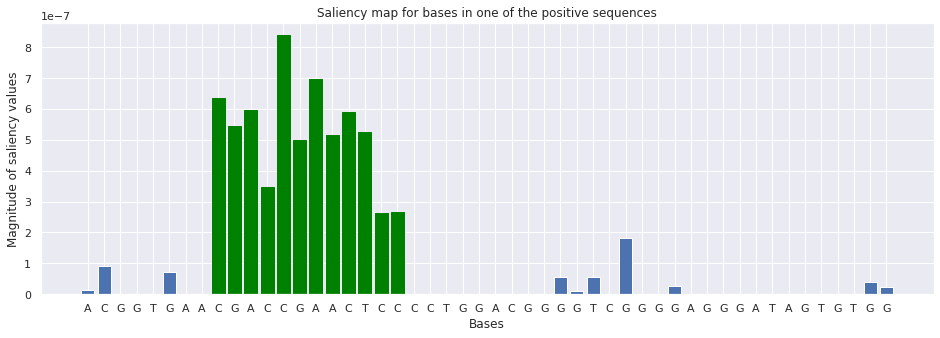

In [214]:
def calculate_saliency(model, x):
  input_tensors = [model.input]
  gradients = model.optimizer.get_gradients(model.output[0][1], model.input)
  compute_gradients = k.function(inputs = input_tensors, outputs = gradients)
  
  x_value = np.expand_dims(x, axis=0)
  gradients = compute_gradients([x_value])[0][0]
  sal = np.clip(np.sum(np.multiply(gradients,x), axis=0),a_min=0, a_max=None)
  return sal


ls = np.argmax(labels, 1)
positive = np.where(ls==1.0)[0]
choice = np.random.choice(positive, 1)[0]
print(choice)

# Search for sequence span
res = re.search('CGACCGAACTCC', sequences[choice])
start, end = res.start(), res.end()

# Get and plot saliency
sal = np.squeeze(calculate_saliency(model, encoded_sequences[choice]), 1)
sns.set_theme()
plt.figure(figsize=[16,5])
barlist = plt.bar(np.arange(len(sal)), sal)
[barlist[i].set_color('green') for i in range(start,end+1)]
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.ylim(ymin=0)
plt.xticks(np.arange(len(sal)), list(sequences[choice]));
plt.title('Saliency map for bases in one of the positive sequences');



The actual transcrption binding site is the sequence ***CGACCGAACTCC***. This sequence will always have a high saliency score. There are also better libraries out there that can compute the importance/saliency scores and generate nicer images. I recommend **DeepLIFT**.